# 1. Setup and Get Data

### 1.1 Collect finger images using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [254]:
IMAGES_PATH = os.path.join("data", "images")
number_images = 10

In [18]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x29dbcb0) is not the object's thread (0x36fa080).
Cannot move to target thread (0x29dbcb0)

QObject::moveToThread: Current thread (0x29dbcb0) is not the object's thread (0x36fa080).
Cannot move to target thread (0x29dbcb0)

QObject::moveToThread: Current thread (0x29dbcb0) is not the object's thread (0x36fa080).
Cannot move to target thread (0x29dbcb0)

QObject::moveToThread: Current thread (0x29dbcb0) is not the object's thread (0x36fa080).
Cannot move to target thread (0x29dbcb0)

QObject::moveToThread: Current thread (0x29dbcb0) is not the object's thread (0x36fa080).
Cannot move to target thread (0x29dbcb0)

QObject::moveToThread: Current thread (0x29dbcb0) is not the object's thread (0x36fa080).
Cannot move to target thread (0x29dbcb0)

QObject::moveToThread: Current thread (0x29dbcb0) is not the object's thread (0x36fa080).
Cannot move to target thread (0x29dbcb0)

QObject::moveToThread: Current thread (0x29dbcb0) is not the object's thread

### 1.2 Label Images with LabelMe

In [255]:
# This step was performed using an app called "labelme" and i drew bounding boxes around my hand in each of them

### 2. Data Loading Function

In [2]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

2024-02-11 11:12:07.696940: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-11 11:12:07.885707: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 11:12:07.885833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 11:12:07.918242: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-11 11:12:07.989196: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-11 11:12:07.990548: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [257]:
images = tf.data.Dataset.list_files("data/images/*.jpg")

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data/images/*.jpg'

In [258]:
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

In [4]:
def load_image(x):
    init_img = tf.io.read_file(x)
    final_img = tf.io.decode_jpeg(init_img)
    
    return final_img

In [260]:
images = images.map(load_image)

NameError: name 'images' is not defined

In [32]:
images.as_numpy_iterator().next()

array([[[164, 119,  98],
        [167, 122, 101],
        [169, 124, 105],
        ...,
        [147, 129, 119],
        [144, 127, 117],
        [151, 134, 124]],

       [[167, 122, 101],
        [169, 124, 103],
        [170, 125, 106],
        ...,
        [154, 136, 126],
        [149, 132, 122],
        [150, 133, 123]],

       [[170, 125, 106],
        [171, 126, 107],
        [171, 126, 107],
        ...,
        [156, 138, 128],
        [150, 133, 123],
        [149, 132, 122]],

       ...,

       [[248, 248, 248],
        [248, 248, 248],
        [248, 248, 248],
        ...,
        [ 21,  21,  19],
        [ 21,  21,  19],
        [ 21,  21,  19]],

       [[248, 248, 248],
        [248, 248, 248],
        [248, 248, 248],
        ...,
        [ 22,  22,  22],
        [ 20,  22,  21],
        [ 20,  22,  21]],

       [[248, 248, 248],
        [248, 248, 248],
        [248, 248, 248],
        ...,
        [ 21,  21,  21],
        [ 19,  21,  20],
        [ 19,  21,  20]]

In [33]:
image_generator = images.batch(4).as_numpy_iterator()

In [34]:
image_samples = image_generator.next()

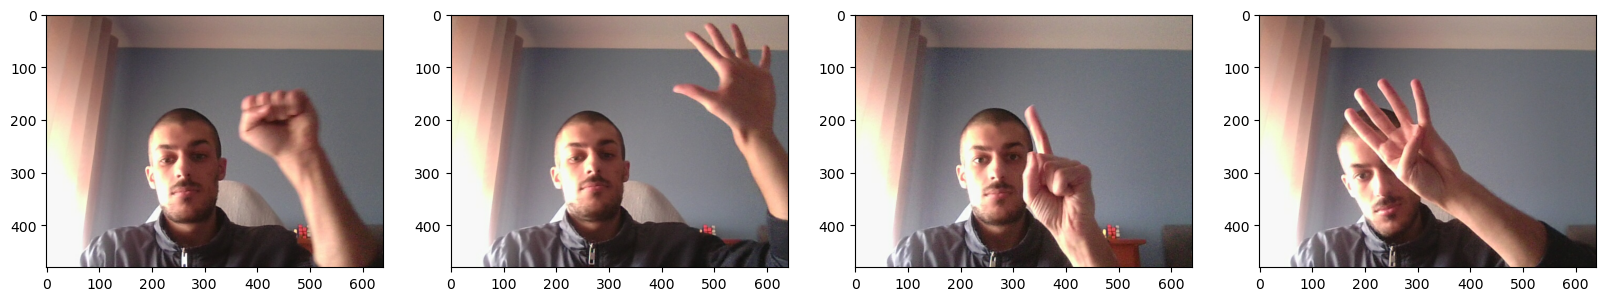

In [36]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(image_samples):
    ax[idx].imshow(image)
plt.show()

# 3. Partition Unaugmented Data

### 3.1 Partition Images

In [42]:
# Train size, Val size, Test size
print(f"Train size: {120*0.7}\nVal size: {120*0.15}\nTest size: {120*0.15}")

Train size: 84.0
Val size: 18.0
Test size: 18.0


### 3.2 Partition Labels

In [45]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Pipeline

In [3]:
import albumentations as alb

In [410]:
augmentor = alb.Compose([alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                         bbox_params=alb.BboxParams(format='albumentations', 
                                                    label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [411]:
img = cv2.imread(os.path.join('data','train', 'images','7893a9ac-c81c-11ee-9204-02421f667b9f.jpg'))

In [412]:
img.shape

(480, 640, 3)

In [413]:
with open(os.path.join('data', 'train', 'labels', '7893a9ac-c81c-11ee-9204-02421f667b9f.json'), 'r') as f:
    label = json.load(f)

In [414]:
print(f"Class: {label['shapes'][0]['label']}") # This is the class
print(f"Coordinates: {label['shapes'][0]['points']}") # These are the bounding box coordinates

Class: 0
Coordinates: [[263.1472081218274, 101.42131979695432], [418.4771573604061, 249.13705583756348]]


### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [415]:
coords = [0,0,0,0]
coords[0] = label["shapes"][0]["points"][0][0]
coords[1] = label["shapes"][0]["points"][0][1]
coords[2] = label["shapes"][0]["points"][1][0]
coords[3] = label["shapes"][0]["points"][1][1]

In [416]:
coords

[263.1472081218274, 101.42131979695432, 418.4771573604061, 249.13705583756348]

In [417]:
coords = list(np.divide(coords, [640,480,640,480])) # Divide each coord by the corresponding width and height

In [418]:
coords # Rescaled coords

[0.41116751269035534,
 0.21129441624365483,
 0.6538705583756346,
 0.5190355329949239]

### 4.4 Apply Augmentations and View Results

In [419]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=[label['shapes'][0]['label']])

In [420]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [421]:
augmented["bboxes"][0]

(0.16560631697687533,
 0.1964918217710096,
 0.5107839819514945,
 0.5247490129723633)

In [422]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
              (255,0,0), 2)

array([[[100, 134, 143],
        [101, 137, 146],
        [100, 136, 144],
        ...,
        [ 65,  94, 127],
        [ 63,  92, 125],
        [ 59,  88, 120]],

       [[ 98, 132, 141],
        [100, 134, 143],
        [ 99, 133, 142],
        ...,
        [ 64,  94, 123],
        [ 63,  92, 125],
        [ 62,  91, 123]],

       [[102, 133, 143],
        [100, 134, 143],
        [101, 132, 142],
        ...,
        [ 65,  95, 125],
        [ 61,  90, 122],
        [ 58,  87, 119]],

       ...,

       [[ 42,  49,  40],
        [ 46,  53,  43],
        [ 46,  53,  43],
        ...,
        [229, 249, 238],
        [229, 249, 238],
        [229, 249, 238]],

       [[ 41,  48,  39],
        [ 43,  50,  41],
        [ 44,  51,  42],
        ...,
        [229, 249, 238],
        [229, 249, 238],
        [229, 249, 238]],

       [[ 42,  50,  41],
        [ 39,  45,  38],
        [ 39,  45,  38],
        ...,
        [229, 249, 238],
        [229, 249, 238],
        [229, 249, 238]]

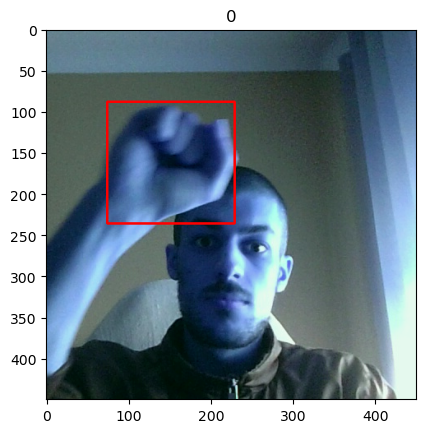

In [423]:
plt.imshow(augmented['image'])
plt.title(augmented['class_labels'][0])
plt.show()

In [424]:
label['shapes'][0]['label']

'0'

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [425]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=[label['shapes'][0]['label']])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                #if os.path.exists(label_path):
                #    annotation['image'] = image
                #    annotation['bbox'] = augmented['bboxes'][0]
                #    annotation['class'] = int(label['shapes'][0]['label'])

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = int(label['shapes'][0]['label']) 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = int(label['shapes'][0]['label'])
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = int(label['shapes'][0]['label'])


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset Format

In [12]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [13]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [14]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [15]:
len(train_images), len(val_images), len(test_images)

(5040, 1080, 1080)

In [16]:
train_images.as_numpy_iterator().next()

array([[[0.42107844, 0.4       , 0.42058823],
        [0.2639093 , 0.2276348 , 0.24675246],
        [0.2329657 , 0.18590686, 0.20159313],
        ...,
        [0.08265931, 0.06697304, 0.06305147],
        [0.07267157, 0.06783088, 0.05343137],
        [0.07359069, 0.07751226, 0.05790441]],

       [[0.3720588 , 0.33909315, 0.3683211 ],
        [0.2579044 , 0.21427695, 0.23682599],
        [0.23431373, 0.1872549 , 0.20196079],
        ...,
        [0.09019608, 0.07450981, 0.07058824],
        [0.07892157, 0.075     , 0.06115196],
        [0.07843138, 0.07726716, 0.06556372]],

       [[0.31580883, 0.27267158, 0.30404413],
        [0.2773897 , 0.22990195, 0.246875  ],
        [0.25042892, 0.19160539, 0.2033701 ],
        ...,
        [0.06672794, 0.06280638, 0.05496323],
        [0.07450981, 0.07058824, 0.0627451 ],
        [0.07579657, 0.07579657, 0.06795343]],

       ...,

       [[0.32800245, 0.24564952, 0.26525736],
        [0.32916668, 0.24828431, 0.26501226],
        [0.34050244, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [17]:
def load_labels(label_path):
    with open(label_path.numpy(), "r", encoding="utf-8") as f:
        label = json.load(f)
        
    return [label["class"]], label["bbox"]

### 6.2 Load Labels to Tensorflow Dataset

In [18]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [19]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [20]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [21]:
train_iterator = train_labels.as_numpy_iterator()

In [22]:
train_iterator.next()

(array([0], dtype=uint8),
 array([0.2426, 0.4685, 0.588 , 0.797 ], dtype=float16))

# 7. Combine Label and Image Samples

In [23]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels) # All good

(5040, 5040, 1080, 1080, 1080, 1080)

### 7.1 Create Final Datasets

In [24]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5500)
train = train.batch(8)
train = train.prefetch(4)

In [25]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1500)
test = test.batch(8)
test = test.prefetch(4)

In [26]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1500)
val = val.batch(8)
val = val.prefetch(4)

In [27]:
train.as_numpy_iterator().next()[1]

(array([[5],
        [2],
        [0],
        [2],
        [0],
        [4],
        [3],
        [2]], dtype=uint8),
 array([[0.678  , 0.3064 , 1.     , 0.9224 ],
        [0.3901 , 0.0786 , 0.786  , 0.709  ],
        [0.338  , 0.4844 , 0.71   , 0.8013 ],
        [0.0961 , 0.1165 , 0.574  , 0.679  ],
        [0.1663 , 0.4963 , 0.499  , 0.811  ],
        [0.454  , 0.1039 , 0.884  , 0.608  ],
        [0.04617, 0.1702 , 0.54   , 0.892  ],
        [0.     , 0.09875, 0.275  , 0.769  ]], dtype=float16))

In [28]:
data_samples = train.as_numpy_iterator()

In [29]:
res = data_samples.next()

In [30]:
res[0].shape # 8 images in each batch

(8, 120, 120, 3)

In [31]:
res[1][0]

array([[3],
       [4],
       [4],
       [5],
       [4],
       [0],
       [0],
       [5]], dtype=uint8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/bruno/anaconda3/lib/python3.11/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


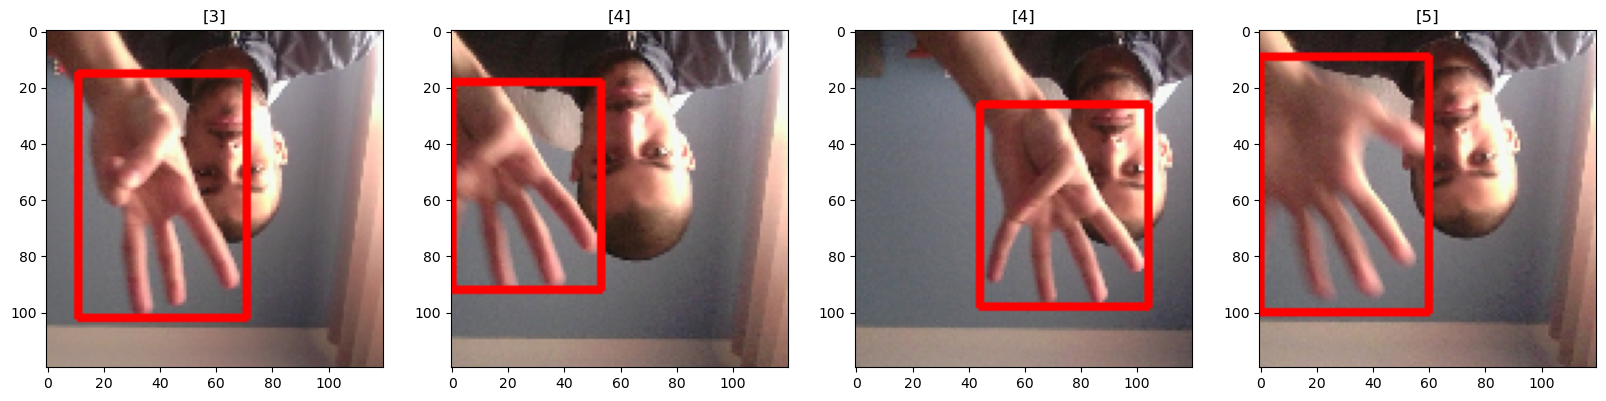

In [32]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx].copy()
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                       (255,0,0), 2)

    ax[idx].imshow(sample_image)
    ax[idx].set_title(res[1][0][idx])

# Build the model on top VGG-16 NN using Transfer Learning

In [33]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG16

In [34]:
vgg = VGG16(include_top=False)

In [35]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [36]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(6, activation='softmax')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    fingertracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return fingertracker

In [37]:
fingertracker = build_model()

In [38]:
fingertracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [39]:
X, y = train.as_numpy_iterator().next()

In [40]:
X.shape

(8, 120, 120, 3)

In [41]:
classes, coords = fingertracker.predict(X)

1/1 [==============================] - 0s 346ms/step


In [42]:
classes, coords

(array([[0.03708523, 0.48514086, 0.08296814, 0.07174236, 0.25330046,
         0.06976292],
        [0.04867619, 0.49214032, 0.06815396, 0.06435698, 0.25662875,
         0.07004367],
        [0.0540148 , 0.36673707, 0.07563258, 0.07580686, 0.35703722,
         0.07077133],
        [0.06755628, 0.4336032 , 0.07250474, 0.08501137, 0.26401535,
         0.07730902],
        [0.03235248, 0.41641915, 0.05660387, 0.0753941 , 0.34399962,
         0.07523072],
        [0.03919013, 0.40564632, 0.0791854 , 0.07152389, 0.35664827,
         0.0478059 ],
        [0.03159245, 0.396563  , 0.05575521, 0.06772365, 0.39420962,
         0.05415605],
        [0.03838196, 0.46538147, 0.05948075, 0.07813552, 0.29662433,
         0.06199589]], dtype=float32),
 array([[0.73031473, 0.55133647, 0.6711565 , 0.5304963 ],
        [0.7330635 , 0.5723203 , 0.56535643, 0.54623586],
        [0.5590659 , 0.49692374, 0.53304917, 0.6115681 ],
        [0.6145863 , 0.5119973 , 0.50794137, 0.5571538 ],
        [0.6270452 , 0.

# 9. Define Losses and Optimizers

In [43]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1)/batches_per_epoch

In [44]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.1 Create localization loss and classification loss

In [45]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [46]:
classloss = tf.keras.losses.SparseCategoricalCrossentropy()
regressloss = localization_loss

In [47]:
y[0]

array([[4],
       [3],
       [2],
       [3],
       [2],
       [5],
       [0],
       [0]], dtype=uint8)

In [48]:
y[1]

array([[0.06158, 0.1628 , 0.593  , 0.8003 ],
       [0.427  , 0.1763 , 0.902  , 0.8184 ],
       [0.4067 , 0.1399 , 0.8086 , 0.749  ],
       [0.0847 , 0.4458 , 0.5835 , 1.     ],
       [0.     , 0.10596, 0.283  , 0.805  ],
       [0.     , 0.0966 , 0.4817 , 0.7563 ],
       [0.4768 , 0.2086 , 0.8623 , 0.5337 ],
       [0.2332 , 0.2474 , 0.5996 , 0.5635 ]], dtype=float16)

In [49]:
regressloss(y[1], coords).numpy()

7.22757

In [50]:
classloss(y[0], classes).numpy()

2.723827

# 10. Train

### 10.1 Create Custom Model Class

In [51]:
class FingerTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            y_true = tf.reshape(y[0], [-1])
            y_pred = classes
            
            batch_classloss = self.closs(y_true, y_pred)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        y_true = tf.reshape(y[0], [-1])
        y_pred = classes
        
        batch_classloss = self.closs(y_true, y_pred)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [486]:
model = FingerTracker(fingertracker)

In [487]:
model.compile(opt, classloss, regressloss)

In [488]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [489]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
630/630 [==============================] - 442s 697ms/step - total_loss: 0.4873 - class_loss: 0.4810 - regress_loss: 0.2467 - val_total_loss: 1.3693 - val_class_loss: 1.0106 - val_regress_loss: 0.8640
Epoch 2/10
630/630 [==============================] - 448s 707ms/step - total_loss: 0.0648 - class_loss: 0.0248 - regress_loss: 0.0524 - val_total_loss: 0.0639 - val_class_loss: 0.0102 - val_regress_loss: 0.0588
Epoch 3/10
630/630 [==============================] - 464s 733ms/step - total_loss: 0.0406 - class_loss: 0.0122 - regress_loss: 0.0345 - val_total_loss: 0.0720 - val_class_loss: 0.0085 - val_regress_loss: 0.0677
Epoch 4/10
630/630 [==============================] - 495s 783ms/step - total_loss: 0.0338 - class_loss: 0.0054 - regress_loss: 0.0311 - val_total_loss: 0.1128 - val_class_loss: 0.0410 - val_regress_loss: 0.0923
Epoch 5/10
630/630 [==============================] - 517s 817ms/step - total_loss: 0.0264 - class_loss: 0.0037 - regress_loss: 0.0246 - val_total_loss:

### 10.2 Plot Performance

In [490]:
hist.history

{'total_loss': [0.062028564512729645,
  0.0394834503531456,
  0.018691670149564743,
  0.011723319999873638,
  0.009070205502212048,
  0.006409219466149807,
  0.02630641683936119,
  0.008375929668545723,
  0.4571402668952942,
  0.007061264477670193],
 'class_loss': [0.01683240756392479,
  0.014884554781019688,
  0.0011176669504493475,
  0.00034572824370115995,
  0.0003380623529665172,
  0.0002437297225696966,
  0.019614361226558685,
  0.00023710294044576585,
  0.006628453731536865,
  0.00018166517838835716],
 'regress_loss': [0.0536123588681221,
  0.03204117342829704,
  0.018132837489247322,
  0.011550456285476685,
  0.008901174180209637,
  0.00628735451027751,
  0.016499236226081848,
  0.00825737789273262,
  0.45382604002952576,
  0.0069704316556453705],
 'val_total_loss': [1.3692591190338135,
  0.06390576809644699,
  0.0720103308558464,
  0.11278952658176422,
  0.9757132530212402,
  0.020171429961919785,
  0.10381309688091278,
  0.020445138216018677,
  0.020980877801775932,
  0.031890

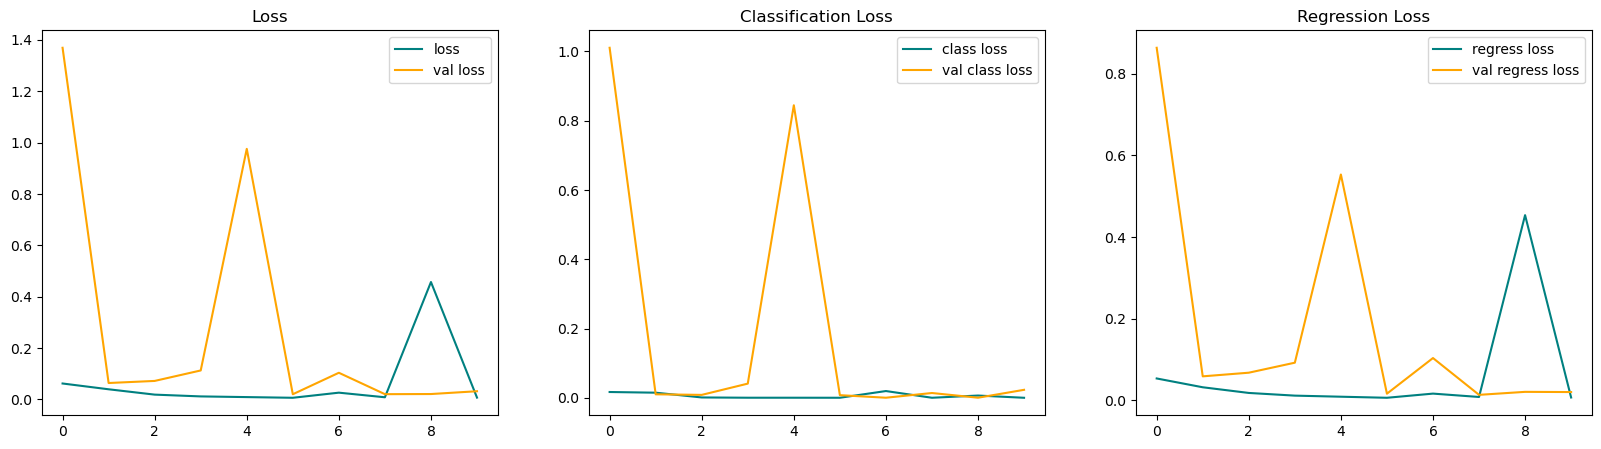

In [491]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions on the Test Set

In [9]:
test_data = test.as_numpy_iterator()

NameError: name 'test' is not defined

In [528]:
test_sample = test_data.next()

In [529]:
yhat = fingertracker.predict(test_sample[0])

1/1 [==============================] - 0s 132ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


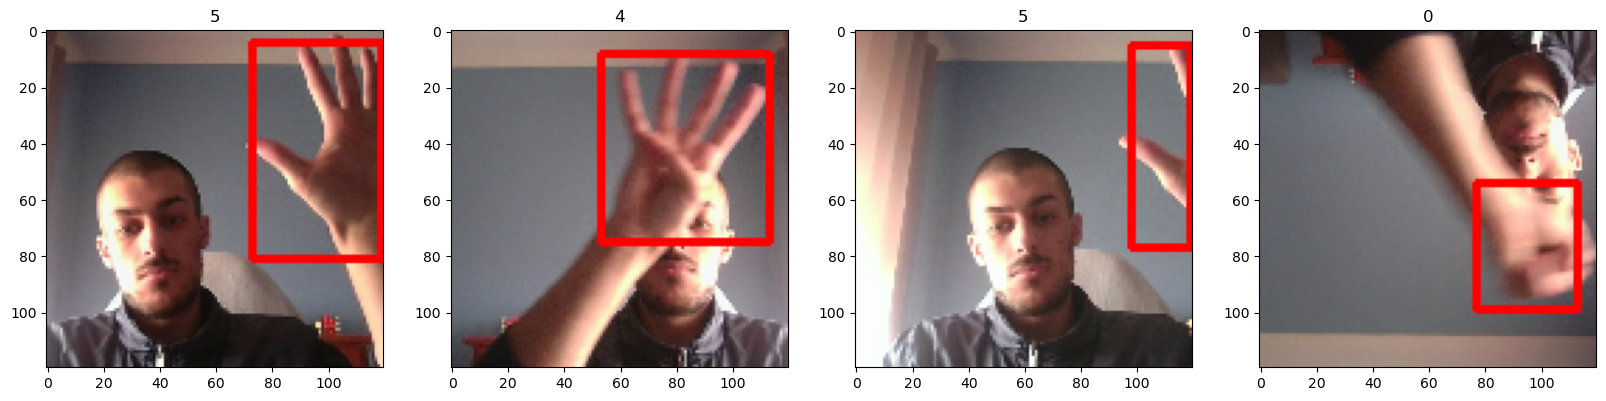

In [530]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx].copy()
    sample_coords = yhat[1][idx]
    
    #if yhat[0][idx] > 0.5:
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)
    
    ax[idx].set_title(yhat[0][idx].argmax())
    ax[idx].imshow(sample_image)

### 11.1 Save the Model

In [5]:
from tensorflow.keras.models import load_model

In [503]:
fingertracker.save("fingertracker.h5")

/home/bruno/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
fingertracker = load_model("fingertracker_gc.h5")

# 12. Real Time Detection

In [7]:
import cv2
import tensorflow as tf
import numpy as np

In [10]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = fingertracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    #if yhat[0] > 0.5: 
    # Controls the main rectangle
    cv2.rectangle(frame,
                  tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                        (255,0,0), 2)
    # Controls the label rectangle
    cv2.rectangle(frame, 
                  tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                [0,-30])),
                  tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                [80,0])), 
                        (255,0,0), -1)

    # Controls the text rendered
    cv2.putText(frame, str(yhat[0].argmax()), tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                           [0,-5])),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 39ms/step


QObject::moveToThread: Current thread (0x803b680) is not the object's thread (0x7ed8b60).
Cannot move to target thread (0x803b680)

QObject::moveToThread: Current thread (0x803b680) is not the object's thread (0x7ed8b60).
Cannot move to target thread (0x803b680)

QObject::moveToThread: Current thread (0x803b680) is not the object's thread (0x7ed8b60).
Cannot move to target thread (0x803b680)

QObject::moveToThread: Current thread (0x803b680) is not the object's thread (0x7ed8b60).
Cannot move to target thread (0x803b680)

QObject::moveToThread: Current thread (0x803b680) is not the object's thread (0x7ed8b60).
Cannot move to target thread (0x803b680)

QObject::moveToThread: Current thread (0x803b680) is not the object's thread (0x7ed8b60).
Cannot move to target thread (0x803b680)

QObject::moveToThread: Current thread (0x803b680) is not the object's thread (0x7ed8b60).
Cannot move to target thread (0x803b680)

QObject::moveToThread: Current thread (0x803b680) is not the object's thread

1/1 [==============================] - 0s 32ms/step
